# Heart Failure Prediction — ANN (PyTorch) · Jupyter Notebook

This notebook builds and trains an **Artificial Neural Network (ANN / MLP)** model for **Heart Failure Prediction** using clinical data.  
If the dataset is not available, it automatically generates a **synthetic dataset** with a schema similar to the *UCI Heart Failure Clinical Records* dataset.

---

### Project Structure
project/
├── Heart_Failure_ANN.ipynb # main notebook
└── data/
└── heart_failure.csv # optional, real dataset (UCI format)


> 💡 If `heart_failure.csv` is missing, the notebook automatically creates synthetic data for demonstration purposes.

---

### Notebook Highlights
- Data loading & preprocessing  
- ANN (MLP) model creation with **PyTorch**  
- Training, validation, and testing pipeline  
- Performance metrics: **Accuracy, Precision, Recall, F1, ROC-AUC**  
- Visualizations: **Loss & Accuracy curves, ROC curve, Confusion Matrix**  
- Model saving options: `.pt`, `.pkl`, or **PDF report** generation  

---

### ⚙️ Dependencies
```bash
pip install torch scikit-learn pandas matplotlib numpy reportlab


| Step                                | Function                             | Result                   |
| ----------------------------------- | ------------------------------------ | ------------------------ |
| `torch.cuda.is_available()`         | Checks if a **GPU** is available     | `True` / `False`         |
| `device = "cuda" if ... else "cpu"` | Selects which device to use          | `"cuda (model runs on your NVIDIA graphics card for faster training)"` or `"cpu (model runs on your main processor)"`      |
| `model.to(device)`                  | Moves the model to the chosen device | Runs on GPU if available |

In [7]:

import os
from pathlib import Path
from dataclasses import dataclass
from typing import List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_recall_fscore_support,
    confusion_matrix, RocCurveDisplay
)

# Tekil grafik kuralına uyacağız: Her grafik ayrı figür.
# Renk belirtilmeyecek (varsayılan stiller).

def set_seed(seed: int = 42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"
set_seed(42)
device


'cpu'

In [8]:
from dataclasses import dataclass
from typing import List

@dataclass
class CFG:
    csv_path: str = "data/heart_failure.csv"   # path to the dataset file
    target: str = "DEATH_EVENT"                # name of the target (label) column
    test_size: float = 0.2                     # portion of data reserved for testing (20%)
    valid_size: float = 0.2                    # portion reserved for validation (20%)
    batch_size: int = 64                       # number of samples processed per training step
    epochs: int = 60                           # number of total training iterations (epochs)
    lr: float = 1e-3                           # learning rate (controls how fast the model learns)
    hidden: List[int] = None                   # hidden layer sizes (e.g. [128, 64])
    dropout: float = 0.2                       # dropout rate (reduces overfitting)
    weight_decay: float = 1e-4                 # L2 regularization term (prevents overfitting)
    seed: int = 42                             # random seed for reproducibility

    def __post_init__(self):
        # set default hidden layer sizes if not provided
        if self.hidden is None:
            self.hidden = [128, 64]

# create configuration object
cfg = CFG()
cfg


CFG(csv_path='data/heart_failure.csv', target='DEATH_EVENT', test_size=0.2, valid_size=0.2, batch_size=64, epochs=60, lr=0.001, hidden=[128, 64], dropout=0.2, weight_decay=0.0001, seed=42)

## Data Loading
- If `data/heart_failure.csv` exists, it will be loaded directly.  
- If not, the notebook automatically generates **synthetic data** similar to the UCI Heart Failure Clinical Records dataset.

**Expected column set** (UCI-compatible):
['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction',
'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium',
'sex', 'smoking', 'time', 'DEATH_EVENT']

> If the dataset is missing, the notebook will still work — synthetic data is generated with similar statistical properties.


In [13]:
def load_or_make_data(cfg: CFG):
    csv_file = Path(cfg.csv_path)
    if csv_file.exists():
        df = pd.read_csv(csv_file)
        if cfg.target not in df.columns:
            raise ValueError(f"Hedef kolon '{cfg.target}' bulunamadı. Kolonlar: {list(df.columns)}")
        df = df.dropna()
        y = df[cfg.target].astype(int)
        X = df.drop(columns=[cfg.target])
        num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
        X = X[num_cols].astype(np.float32)
        return X, y, num_cols, True
    else:
        # ---- SYNTHETIC DATA (similar to UCI format) ----
        from sklearn.datasets import make_classification
        
        cols = [
            'age','anaemia','creatinine_phosphokinase','diabetes','ejection_fraction',
            'high_blood_pressure','platelets','serum_creatinine','serum_sodium',
            'sex','smoking','time','extra_feature'
        ]
        
        X_np, y_np = make_classification(
            n_samples=1200,
            n_features=len(cols),
            n_informative=6,
            n_redundant=4,
            n_repeated=0,
            n_classes=2,
            weights=[0.7, 0.3],
            class_sep=1.2,
            flip_y=0.02,
            random_state=cfg.seed,
        )

        X = pd.DataFrame(X_np.astype(np.float32), columns=cols)
        y = pd.Series(y_np.astype(int), name=cfg.target)
        return X, y, cols, False


| Step                 | Purpose                                |
| -------------------- | -------------------------------------- |
| `train_test_split()` | Split data into train/val/test sets    |
| `StandardScaler()`   | Normalize numeric features             |
| `TensorDataset()`    | Convert NumPy → PyTorch tensors        |
| `DataLoader()`       | Feed data to the model in mini-batches |
| `len(tr_dl)`         | Shows number of batches in each loader |

So, this part is the **data preparation pipeline before model training** — it splits the data, scales it, converts it into tensors, and divides it into batches.


In [15]:
def load_or_make_data(cfg: CFG):
    csv_file = Path(cfg.csv_path)
    if csv_file.exists():
        df = pd.read_csv(csv_file)
        if cfg.target not in df.columns:
            raise ValueError(f"Target column '{cfg.target}' not found in {list(df.columns)}")
        df = df.dropna()
        y = df[cfg.target].astype(int)
        X = df.drop(columns=[cfg.target])
        num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
        X = X[num_cols].astype(np.float32)
        return X, y, num_cols, True
    else:
        from sklearn.datasets import make_classification
        cols = [
            'age','anaemia','creatinine_phosphokinase','diabetes','ejection_fraction',
            'high_blood_pressure','platelets','serum_creatinine','serum_sodium',
            'sex','smoking','time','extra_feature'
        ]
        X_np, y_np = make_classification(
            n_samples=1200,
            n_features=len(cols),
            n_informative=6,
            n_redundant=4,
            n_classes=2,
            weights=[0.7, 0.3],
            class_sep=1.2,
            flip_y=0.02,
            random_state=cfg.seed,
        )
        X = pd.DataFrame(X_np.astype(np.float32), columns=cols)
        y = pd.Series(y_np.astype(int), name=cfg.target)
        return X, y, cols, False

# ✅ Çalıştır:
X, y, cols, is_real = load_or_make_data(cfg)
print("Dataset loaded:", "real" if is_real else "synthetic", "| samples:", len(X))


Dataset loaded: synthetic | samples: 1200


In [16]:

set_seed(cfg.seed)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=cfg.test_size, stratify=y, random_state=cfg.seed)
X_tr, X_va, y_tr, y_va = train_test_split(X_tr, y_tr, test_size=cfg.valid_size, stratify=y_tr, random_state=cfg.seed)

scaler = StandardScaler()
X_tr_s = scaler.fit_transform(X_tr)
X_va_s = scaler.transform(X_va)
X_te_s = scaler.transform(X_te)

tr_ds = TensorDataset(torch.tensor(X_tr_s, dtype=torch.float32), torch.tensor(y_tr.values, dtype=torch.long))
va_ds = TensorDataset(torch.tensor(X_va_s, dtype=torch.float32), torch.tensor(y_va.values, dtype=torch.long))
te_ds = TensorDataset(torch.tensor(X_te_s, dtype=torch.float32), torch.tensor(y_te.values, dtype=torch.long))

tr_dl = DataLoader(tr_ds, batch_size=cfg.batch_size, shuffle=True)
va_dl = DataLoader(va_ds, batch_size=cfg.batch_size, shuffle=False)
te_dl = DataLoader(te_ds, batch_size=cfg.batch_size, shuffle=False)

len(tr_dl), len(va_dl), len(te_dl)


(12, 3, 4)

**MLP:** Defines your neural network architecture

nn.Linear(last, h) → fully connected layer
nn.ReLU() → activation function introducing non-linearity
nn.BatchNorm1d(h) → normalizes activations for stability
nn.Dropout(dropout) → randomly deactivates neurons to reduce overfitting

In [17]:

class MLP(nn.Module):
    def __init__(self, in_dim: int, hidden: List[int], dropout: float = 0.2):
        super().__init__()
        layers: List[nn.Module] = []
        last = in_dim
        for h in hidden:
            layers += [nn.Linear(last, h), nn.ReLU(), nn.BatchNorm1d(h), nn.Dropout(dropout)]
            last = h
        layers += [nn.Linear(last, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze(1)

model = MLP(in_dim=X_tr.shape[1], hidden=cfg.hidden, dropout=cfg.dropout).to(device)
model


MLP(
  (net): Sequential(
    (0): Linear(in_features=13, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)

model → the best trained model
history → a dictionary of all recorded metrics during training (for plotting later)

**train_valid()** trains the model on the training set, evaluates it on validation data after each epoch, saves the best version, and returns both the trained model and its performance history.

In [18]:

def train_valid(model, tr_dl, va_dl, cfg: CFG):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=False)

    hist = {"tr_loss": [], "va_loss": [], "tr_acc": [], "va_acc": []}
    best_state = None
    best_val = float('inf')
    patience, pat = 15, 0

    for epoch in range(1, cfg.epochs+1):
        # train
        model.train()
        tr_loss = 0.0
        y_true, y_pred = [], []
        for xb, yb in tr_dl:
            xb = xb.to(device)
            yb = yb.to(device).float()
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            tr_loss += loss.item() * xb.size(0)
            probs = torch.sigmoid(logits).detach().cpu().numpy()
            y_pred.extend((probs >= 0.5).astype(int))
            y_true.extend(yb.detach().cpu().numpy().astype(int))
        tr_loss /= len(tr_dl.dataset)
        tr_acc = accuracy_score(y_true, y_pred)

        # valid
        model.eval()
        va_loss = 0.0
        y_true, y_prob = [], []
        with torch.no_grad():
            for xb, yb in va_dl:
                xb = xb.to(device)
                yb = yb.to(device).float()
                logits = model(xb)
                loss = criterion(logits, yb)
                va_loss += loss.item() * xb.size(0)
                probs = torch.sigmoid(logits).detach().cpu().numpy()
                y_prob.extend(probs)
                y_true.extend(yb.detach().cpu().numpy().astype(int))
        va_loss /= len(va_dl.dataset)
        va_acc = accuracy_score(y_true, (np.array(y_prob)>=0.5).astype(int))
        try:
            va_auc = roc_auc_score(y_true, y_prob)
        except Exception:
            va_auc = float('nan')

        hist["tr_loss"].append(tr_loss)
        hist["va_loss"].append(va_loss)
        hist["tr_acc"].append(tr_acc)
        hist["va_acc"].append(va_acc)
        scheduler.step(va_loss)

        if va_loss + 1e-6 < best_val:
            best_val = va_loss
            best_state = model.state_dict()
            pat = 0
        else:
            pat += 1
            if pat >= patience:
                break
    if best_state is not None:
        model.load_state_dict(best_state)
    return model, hist

model, history = train_valid(model, tr_dl, va_dl, cfg)
history


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


{'tr_loss': [0.5884477098782858,
  0.4490220795075099,
  0.3949262996514638,
  0.35641175508499146,
  0.3182389661669731,
  0.2858016900718212,
  0.24809419612089792,
  0.23654748871922493,
  0.23163458270331225,
  0.19796237473686537,
  0.1970106673737367,
  0.1855100200821956,
  0.18120916622380415,
  0.1432529054582119,
  0.17143856113155684,
  0.14517032292981943,
  0.13948210018376508,
  0.13209585410853228,
  0.15094201266765594,
  0.14280732721090317,
  0.12715571311612925,
  0.1244905845572551,
  0.12060514899591605,
  0.14091744553297758,
  0.11099922222395738,
  0.11779926779369514,
  0.1025200029835105,
  0.10860863390068214,
  0.11552949311832587,
  0.10303052204350631,
  0.11125225573778152,
  0.10595610365271568,
  0.12577782881756625,
  0.1034430240591367,
  0.10811725320915382,
  0.10510713700205088,
  0.08932331080238025,
  0.08831904456019402,
  0.08068014215677977,
  0.08616244016836087,
  0.08466226141899824,
  0.0887493547052145],
 'va_loss': [0.5682074626286825,
 

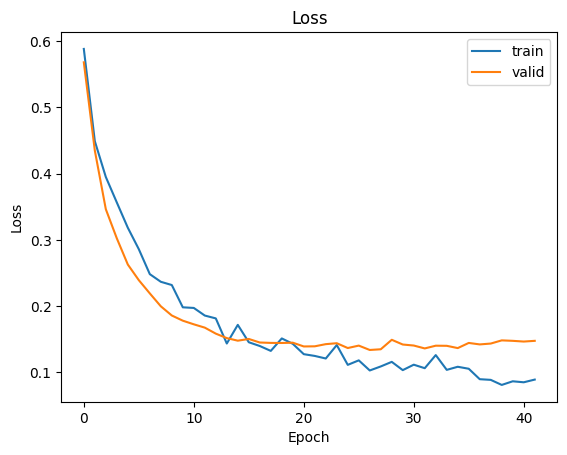

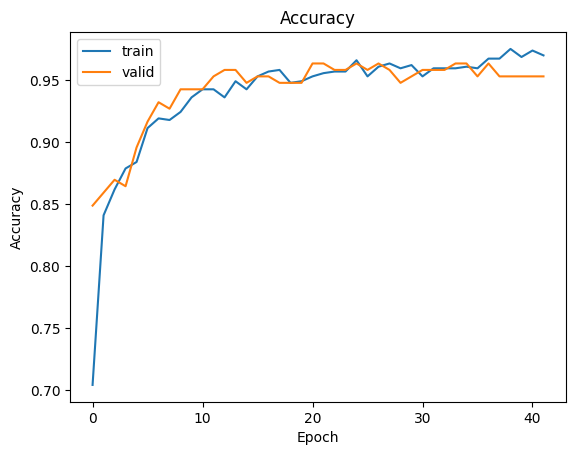

In [19]:

# Loss plot
plt.figure()
plt.title('Loss')
plt.plot(history["tr_loss"], label='train')
plt.plot(history["va_loss"], label='valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy plot
plt.figure()
plt.title('Accuracy')
plt.plot(history["tr_acc"], label='train')
plt.plot(history["va_acc"], label='valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [20]:

# valuates the trained model on test data — computing accuracy, 
# AUC, precision, recall, F1 score, and the confusion matrix (cm) 
# — to measure how well the ANN generalizes to unseen samples.

model.eval()
y_true, y_prob = [], []
with torch.no_grad():
    for xb, yb in te_dl:
        xb = xb.to(device)
        logits = model(xb)
        probs = torch.sigmoid(logits).cpu().numpy()
        y_prob.extend(probs)
        y_true.extend(yb.numpy().astype(int))

y_prob = np.array(y_prob)
y_pred = (y_prob >= 0.5).astype(int)
acc = accuracy_score(y_true, y_pred)
try:
    auc = roc_auc_score(y_true, y_prob)
except Exception:
    auc = float('nan')
pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
cm = confusion_matrix(y_true, y_pred)

print(f"Test -> acc={acc:.3f} | auc={auc:.3f} | precision={pr:.3f} | recall={rc:.3f} | f1={f1:.3f}")
cm


Test -> acc=0.967 | auc=0.981 | precision=0.986 | recall=0.907 | f1=0.944


array([[164,   1],
       [  7,  68]])

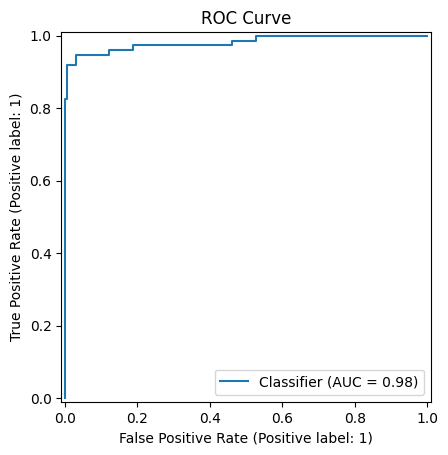

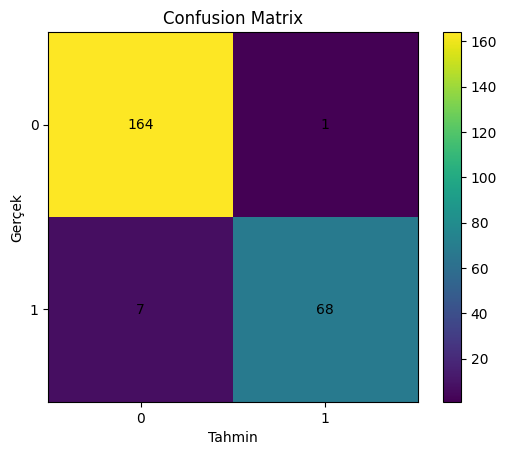

In [21]:

# ROC Curve: (Receiver Operating Characteristic Curve) shows how well a model distinguishes between classes by plotting 
# the True Positive Rate (sensitivity) against the False Positive Rate at different probability thresholds.
fig1, ax1 = plt.subplots()
RocCurveDisplay.from_predictions(y_true, y_prob, ax=ax1)
ax1.set_title("ROC Curve")
plt.show()

# Confusion Matrix heatmap-ish
fig2, ax2 = plt.subplots()
im = ax2.imshow(cm, interpolation='nearest')
ax2.figure.colorbar(im, ax=ax2)
ax2.set(xticks=range(2), yticks=range(2), xticklabels=["0","1"], yticklabels=["0","1"], ylabel='Gerçek', xlabel='Tahmin')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax2.text(j, i, cm[i, j], ha="center", va="center")
ax2.set_title("Confusion Matrix")
plt.show()


##  Single Sample Prediction
The following cell takes one sample from `X_te`, scales it, and returns the model’s prediction.


In [22]:
idx = 0
x = X_te.iloc[[idx]].values.astype(np.float32)
x_s = (x - scaler.mean_) / scaler.scale_
with torch.no_grad():
    p = torch.sigmoid(model(torch.tensor(x_s, dtype=torch.float32).to(device))).item()
print("Sample index:", idx)
print("True label:", int(y_te.iloc[idx]))
print(f"Predicted probability (DEATH_EVENT=1): {p:.3f}")


Sample index: 0
True label: 0
Predicted probability (DEATH_EVENT=1): 0.006


Purpose, Generate a professional-looking PDF report summarizing the model’s performance — including metrics and plots (Loss, Accuracy, ROC, Confusion Matrix).

In [23]:
# Install if not already installed:
# pip install reportlab

from reportlab.lib.pagesizes import A4
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image
from reportlab.lib.styles import getSampleStyleSheet
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

# === Paths / directories ===
pdf_dir = Path("/Users/handanvural/Desktop/heart_failure_project/reports")
pdf_dir.mkdir(exist_ok=True, parents=True)
pdf_path = pdf_dir / "HeartFailure_Report.pdf"

# !!! IMPORTANT: Convert Path -> str for ReportLab
doc = SimpleDocTemplate(str(pdf_path), pagesize=A4)
styles = getSampleStyleSheet()
elements = []

# === Title and metrics ===
elements.append(Paragraph("<b>Heart Failure Prediction — ANN (PyTorch)</b>", styles["Title"]))
elements.append(Spacer(1, 12))

metrics_text = f"""
<b>Test Metrics</b><br/>
Accuracy: {acc:.3f}<br/>
ROC-AUC: {auc:.3f}<br/>
Precision: {pr:.3f}<br/>
Recall: {rc:.3f}<br/>
F1-Score: {f1:.3f}<br/>
"""
elements.append(Paragraph(metrics_text, styles["Normal"]))
elements.append(Spacer(1, 12))

# === Save plots as images ===
loss_img = pdf_dir / "loss_plot.png"
acc_img  = pdf_dir / "acc_plot.png"
roc_img  = pdf_dir / "roc_curve.png"
cm_img   = pdf_dir / "conf_matrix.png"

# Loss curve
plt.figure()
plt.plot(history["tr_loss"], label="Train Loss")
plt.plot(history["va_loss"], label="Validation Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
plt.tight_layout()
plt.savefig(loss_img); plt.close()

# Accuracy curve
plt.figure()
plt.plot(history["tr_acc"], label="Train Accuracy")
plt.plot(history["va_acc"], label="Validation Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()
plt.tight_layout()
plt.savefig(acc_img); plt.close()

# ROC curve
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(y_true, y_prob, ax=ax)
ax.set_title("ROC Curve")
fig.tight_layout()
fig.savefig(roc_img); plt.close(fig)

# Confusion Matrix (simple visualization)
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=range(2), yticks=range(2),
       xticklabels=["0", "1"], yticklabels=["0", "1"],
       ylabel='True Label', xlabel='Predicted Label')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")
ax.set_title("Confusion Matrix")
fig.tight_layout()
fig.savefig(cm_img); plt.close(fig)

# === Add images to the PDF (Image paths must be str) ===
for img in [loss_img, acc_img, roc_img, cm_img]:
    elements.append(Image(str(img), width=400, height=300))
    elements.append(Spacer(1, 12))

# === Build the PDF report ===
doc.build(elements)
print("PDF report saved at:", pdf_path)


PDF report saved at: /Users/handanvural/Desktop/heart_failure_project/reports/HeartFailure_Report.pdf


In [24]:
model, history = train_valid(model, tr_dl, va_dl, cfg)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [26]:
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
ax.set_xlim(0, len(history["tr_loss"]))
ax.set_ylim(0, max(history["tr_loss"]) * 1.1)
ax.set_xlabel("Epoch")
ax.set_ylabel("Training Loss")
ax.set_title("Training Progress (Loss over Epochs)")

line, = ax.plot([], [], lw=2, color="tomato")

def update(frame):
    line.set_data(range(frame), history["tr_loss"][:frame])
    ax.set_title(f"Training Loss — Epoch {frame}/{len(history['tr_loss'])}")
    return line,

ani = FuncAnimation(fig, update, frames=len(history["tr_loss"]), interval=150, repeat=False)
ani.save("training_progress.gif", writer="pillow")
plt.close(fig)
print("GIF saved as training_progress.gif")


GIF saved as training_progress.gif


### Performance Metrics Explained

- **Accuracy:** The ratio of correctly predicted samples to the total number of samples.  
- **ROC-AUC:** Measures how well the model distinguishes between positive and negative classes.  
- **Precision:** The percentage of predicted positives that are actually positive (low false positives).  
- **Recall:** The percentage of actual positives that the model successfully detected (low false negatives).  
- **F1-Score:** The harmonic mean of precision and recall, balancing both metrics into one value.  


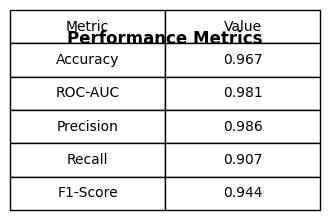

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4, 1.5))
ax.axis('off')
table_data = [
    ["Metric", "Value"],
    ["Accuracy", f"{acc:.3f}"],
    ["ROC-AUC", f"{auc:.3f}"],
    ["Precision", f"{pr:.3f}"],
    ["Recall", f"{rc:.3f}"],
    ["F1-Score", f"{f1:.3f}"],
]
table = ax.table(cellText=table_data, loc='center', cellLoc='center')
table.scale(1, 2)
plt.title("Performance Metrics", weight="bold")
plt.savefig("metrics_table.png", bbox_inches='tight')


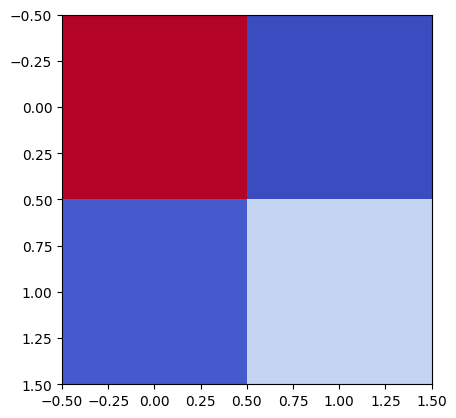

In [29]:
plt.imshow(cm, interpolation='nearest', cmap='coolwarm')
